In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from imageio import imread
import scipy.io
import cv2
import os
import json
from tqdm import tqdm
import pickle

In [2]:
batch_size = 128
maxlen = 20
image_size = 224

MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 3))

def load_data(image_dir, annotation_path):
    with open(annotation_path, 'r') as fr:
        annotation = json.load(fr)
        
    ids = []
    captions = []
    image_dict = {}
    for i in tqdm(range(len(annotation['annotations']))):
        item = annotation['annotations'][i]
        caption = item['caption'].strip().lower()
        caption = caption.replace('.', '').replace(',', '').replace("'", '').replace('"', '')
        caption = caption.replace('&', 'and').replace('(', '').replace(')', '').replace('-', ' ').split()
        caption = [w for w in caption if len(w) > 0]
        
        if len(caption) <= maxlen:
            if not item['image_id'] in image_dict:
                img = imread(image_dir + '%012d.jpg' % item['image_id'])
                h = img.shape[0]
                w = img.shape[1]
                if h > w:
                    img = img[h // 2 - w // 2: h // 2 + w // 2, :]
                else:
                    img = img[:, w // 2 - h // 2: w // 2 + h // 2]   
                img = cv2.resize(img, (image_size, image_size))
                
                if len(img.shape) < 3:
                    img = np.expand_dims(img, -1)
                    img = np.concatenate([img, img, img], axis=-1)
                
                image_dict[item['image_id']] = img
            
            ids.append(item['image_id'])
            captions.append(caption)
    
    return ids, captions, image_dict

train_json = 'data/train/captions_train2014.json'
train_ids, train_captions, train_dict = load_data('data/train/images/COCO_train2014_', train_json)
print(len(train_ids))

100%|██████████| 414113/414113 [11:10<00:00, 617.48it/s] 


411593


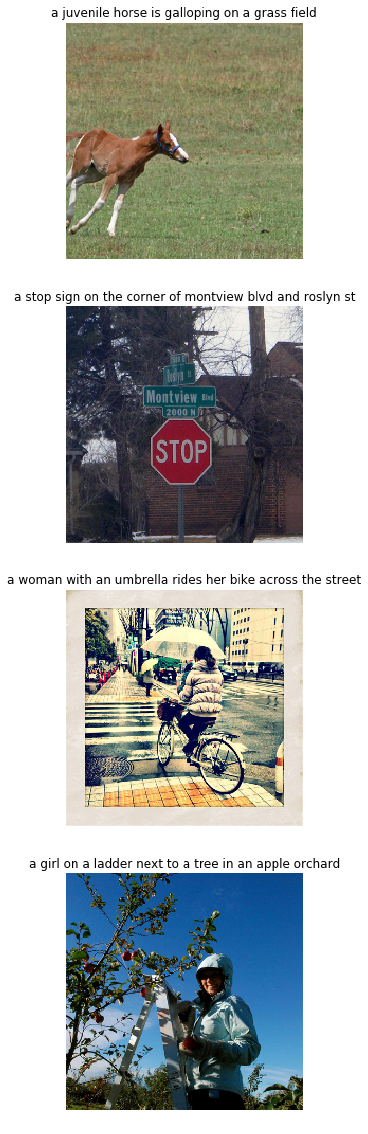

In [3]:
data_index = np.arange(len(train_ids))
np.random.shuffle(data_index)
N = 4
data_index = data_index[:N]
plt.figure(figsize=(12, 20))
for i in range(N):
    caption = train_captions[data_index[i]]
    img = train_dict[train_ids[data_index[i]]]
    plt.subplot(4, 1, i + 1)
    plt.imshow(img)
    plt.title(' '.join(caption))
    plt.axis('off')

In [4]:
vocabulary = {}
for caption in train_captions:
    for word in caption:
        vocabulary[word] = vocabulary.get(word, 0) + 1

vocabulary = sorted(vocabulary.items(), key=lambda x:-x[1])
vocabulary = [w[0] for w in vocabulary]

word2id = {'<pad>': 0, '<start>': 1, '<end>': 2}
for i, w in enumerate(vocabulary):
    word2id[w] = i + 3
id2word = {i: w for w, i in word2id.items()}

print(len(vocabulary), vocabulary[:20])

with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([vocabulary, word2id, id2word], fw)

def translate(ids):
    words = [id2word[i] for i in ids if i >= 3]
    return ' '.join(words) + '.'

23728 ['a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'an', 'two', 'standing', 'at', 'people', 'are', 'next', 'white', 'woman']


In [5]:
def convert_captions(data):
    result = []
    for caption in data:
        vector = [word2id['<start>']]
        for word in caption:
            if word in word2id:
                vector.append(word2id[word])
        vector.append(word2id['<end>'])
        result.append(vector)
        
    array = np.zeros((len(data), maxlen + 2), np.int32)
    for i in tqdm(range(len(result))):
        array[i, :len(result[i])] = result[i]
    return array

train_captions = convert_captions(train_captions)
print(train_captions.shape)
print(train_captions[0])
print(translate(train_captions[0]))

100%|██████████| 411593/411593 [00:00<00:00, 418182.64it/s]

(411593, 22)
[  1   3 141 503   9 629 414 274  57   2   0   0   0   0   0   0   0   0
   0   0   0   0]
a very clean and well decorated empty bathroom.


In [6]:
vgg = scipy.io.loadmat('imagenet-vgg-verydeep-19.mat')
vgg_layers = vgg['layers']

def vgg_endpoints(inputs, reuse=None):
    with tf.variable_scope('endpoints', reuse=reuse):
        def _weights(layer, expected_layer_name):
            W = vgg_layers[0][layer][0][0][2][0][0]
            b = vgg_layers[0][layer][0][0][2][0][1]
            layer_name = vgg_layers[0][layer][0][0][0][0]
            assert layer_name == expected_layer_name
            return W, b

        def _conv2d_relu(prev_layer, layer, layer_name):
            W, b = _weights(layer, layer_name)
            W = tf.constant(W)
            b = tf.constant(np.reshape(b, (b.size)))
            return tf.nn.relu(tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b)

        def _avgpool(prev_layer):
            return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        graph = {}
        graph['conv1_1']  = _conv2d_relu(inputs, 0, 'conv1_1')
        graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
        graph['avgpool1'] = _avgpool(graph['conv1_2'])
        graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
        graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
        graph['avgpool2'] = _avgpool(graph['conv2_2'])
        graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
        graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
        graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
        graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
        graph['avgpool3'] = _avgpool(graph['conv3_4'])
        graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
        graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
        graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
        graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
        graph['avgpool4'] = _avgpool(graph['conv4_4'])
        graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
        graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
        graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
        graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
        graph['avgpool5'] = _avgpool(graph['conv5_4'])

        return graph

X = tf.placeholder(tf.float32, [None, image_size, image_size, 3])
encoded = vgg_endpoints(X - MEAN_VALUES)['conv5_3']
print(encoded)

Tensor("endpoints/Relu_14:0", shape=(?, 14, 14, 512), dtype=float32)


In [7]:
k_initializer = tf.contrib.layers.xavier_initializer()
b_initializer = tf.constant_initializer(0.0)
e_initializer = tf.random_uniform_initializer(-1.0, 1.0)

def dense(inputs, units, activation=tf.nn.tanh, use_bias=True, name=None):
    return tf.layers.dense(inputs, units, activation, use_bias,
                           kernel_initializer=k_initializer, bias_initializer=b_initializer, name=name)

def batch_norm(inputs, name):
    return tf.contrib.layers.batch_norm(inputs, decay=0.95, center=True, scale=True, is_training=True, 
                                        updates_collections=None, scope=name)

def dropout(inputs):
    return tf.layers.dropout(inputs, rate=0.5, training=True)

num_block = 14 * 14
num_filter = 512
hidden_size = 1024
embedding_size = 512

encoded = tf.reshape(encoded, [-1, num_block, num_filter]) # batch_size, num_block, num_filter
contexts = batch_norm(encoded, 'contexts')

Y = tf.placeholder(tf.int32, [None, maxlen + 2])
Y_in = Y[:, :-1]
Y_out = Y[:, 1:]
mask = tf.to_float(tf.not_equal(Y_out, word2id['<pad>']))

with tf.variable_scope('initialize'):
    context_mean = tf.reduce_mean(contexts, 1)
    state = dense(context_mean, hidden_size, name='initial_state')
    memory = dense(context_mean, hidden_size, name='initial_memory')
    
with tf.variable_scope('embedding'):
    embeddings = tf.get_variable('weights', [len(word2id), embedding_size], initializer=e_initializer)
    embedded = tf.nn.embedding_lookup(embeddings, Y_in)
    
with tf.variable_scope('projected'):
    projected_contexts = tf.reshape(contexts, [-1, num_filter]) # batch_size * num_block, num_filter
    projected_contexts = dense(projected_contexts, num_filter, activation=None, use_bias=False, name='projected_contexts')
    projected_contexts = tf.reshape(projected_contexts, [-1, num_block, num_filter]) # batch_size, num_block, num_filter

lstm = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
loss = 0
alphas = []

In [8]:
for t in range(maxlen + 1):
    with tf.variable_scope('attend'):
        h0 = dense(state, num_filter, activation=None, name='fc_state') # batch_size, num_filter
        h0 = tf.nn.relu(projected_contexts + tf.expand_dims(h0, 1)) # batch_size, num_block, num_filter
        h0 = tf.reshape(h0, [-1, num_filter]) # batch_size * num_block, num_filter
        h0 = dense(h0, 1, activation=None, use_bias=False, name='fc_attention') # batch_size * num_block, 1
        h0 = tf.reshape(h0, [-1, num_block]) # batch_size, num_block
        
        alpha = tf.nn.softmax(h0) # batch_size, num_block
        # contexts:                 batch_size, num_block, num_filter
        # tf.expand_dims(alpha, 2): batch_size, num_block, 1
        context = tf.reduce_sum(contexts * tf.expand_dims(alpha, 2), 1, name='context') # batch_size, num_filter
        alphas.append(alpha)
        
    with tf.variable_scope('selector'):
        beta = dense(state, 1, activation=tf.nn.sigmoid, name='fc_beta') # batch_size, 1
        context = tf.multiply(beta, context, name='selected_context')  # batch_size, num_filter
        
    with tf.variable_scope('lstm'):
        h0 = tf.concat([embedded[:, t, :], context], 1) # batch_size, embedding_size + num_filter
        _, (memory, state) = lstm(inputs=h0, state=[memory, state])
    
    with tf.variable_scope('decode'):
        h0 = dropout(state)
        h0 = dense(h0, embedding_size, activation=None, name='fc_logits_state')
        h0 += dense(context, embedding_size, activation=None, use_bias=False, name='fc_logits_context')
        h0 += embedded[:, t, :]
        h0 = tf.nn.tanh(h0)
        
        h0 = dropout(h0)
        logits = dense(h0, len(word2id), activation=None, name='fc_logits')
    
    loss += tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_out[:, t], logits=logits) * mask[:, t])
    tf.get_variable_scope().reuse_variables()

In [9]:
alphas = tf.transpose(tf.stack(alphas), (1, 0, 2)) # batch_size, maxlen + 1, num_block
alphas = tf.reduce_sum(alphas, 1) # batch_size, num_block
attention_loss = tf.reduce_sum(((maxlen + 1) / num_block - alphas) ** 2)
total_loss = (loss + attention_loss) / batch_size

with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
    global_step = tf.Variable(0, trainable=False)
    vars_t = [var for var in tf.trainable_variables() if not var.name.startswith('endpoints')]
    train = tf.contrib.layers.optimize_loss(total_loss, global_step, 0.001, 'Adam', clip_gradients=5.0, variables=vars_t)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
OUTPUT_DIR = 'model'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

tf.summary.scalar('losses/loss', loss)
tf.summary.scalar('losses/attention_loss', attention_loss)
tf.summary.scalar('losses/total_loss', total_loss)
summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(OUTPUT_DIR)

epochs = 20
for e in range(epochs):
    train_ids, train_captions = shuffle(train_ids, train_captions)
    for i in tqdm(range(len(train_ids) // batch_size)):
        X_batch = np.array([train_dict[x] for x in train_ids[i * batch_size: i * batch_size + batch_size]])
        Y_batch = train_captions[i * batch_size: i * batch_size + batch_size]

        _ = sess.run(train, feed_dict={X: X_batch, Y: Y_batch})

        if i > 0 and i % 100 == 0:
            writer.add_summary(sess.run(summary, 
                                        feed_dict={X: X_batch, Y: Y_batch}), 
                                        e * len(train_ids) // batch_size + i)
            writer.flush()
            
    saver.save(sess, os.path.join(OUTPUT_DIR, 'image_caption'))

 90%|█████████ | 2903/3215 [30:41<03:43,  1.40it/s]